# 參數設定 (VMD + 使用訊號分解 EEMD)

In [1]:
import os

labels = ['GroupCount']
model_type = 2 # 使用模型
predicteds = [2,4,6] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1
vmd_k = 8 # VMD分解層數
std_num = 1 # 標準差倍數
sigma = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例

is_emd = False # 是否使用 EMD，False 則使用 EEMD 
 
model_dir = 'VMD_DecompEEMD/_Model'

# !pip install EMD-signal
# https://github.com/laszukdawid/PyEMD/tree/master

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.x_scaler.pkl
y_scaler_file_name: VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.y_scaler.pkl
model_file_name: VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.model.keras
result_file_name: VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.result.json
檔案 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.result.json 存在，已刪除


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,"[2, 4, 6]",377381,954685,78374,23,1093,59,1164,1,0,0,10,0,0,1175
1,2023-04-03,"[2, 4, 6]",496147,1220042,83113,22,1414,80,1515,1,0,0,0,0,0,1516
2,2023-04-04,"[2, 4, 6]",435691,1054023,70665,25,1254,72,1351,0,0,0,0,0,0,1351
3,2023-04-05,"[2, 4, 6]",513216,1321385,123195,35,1493,78,1601,4,0,0,1,0,0,1606
4,2023-04-06,"[2, 4, 6]",1256282,3160850,212372,40,3717,78,3833,2,0,0,0,0,0,3835


# VMD 訊號分解

In [5]:
data_source = df_source[labels].values
u = lstm.vmd_decomposition(data_source, K = vmd_k)

print(data_source.shape)
print(u.shape)  

(395, 1)
(8, 394)


# 繪製 VMD 訊號分解圖

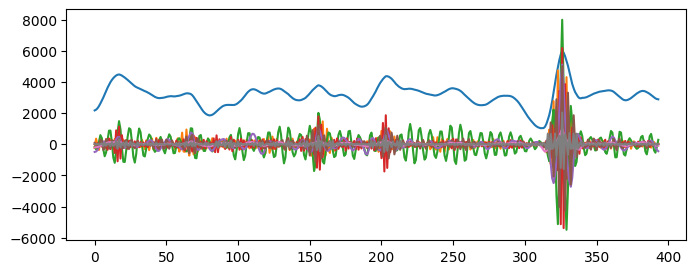

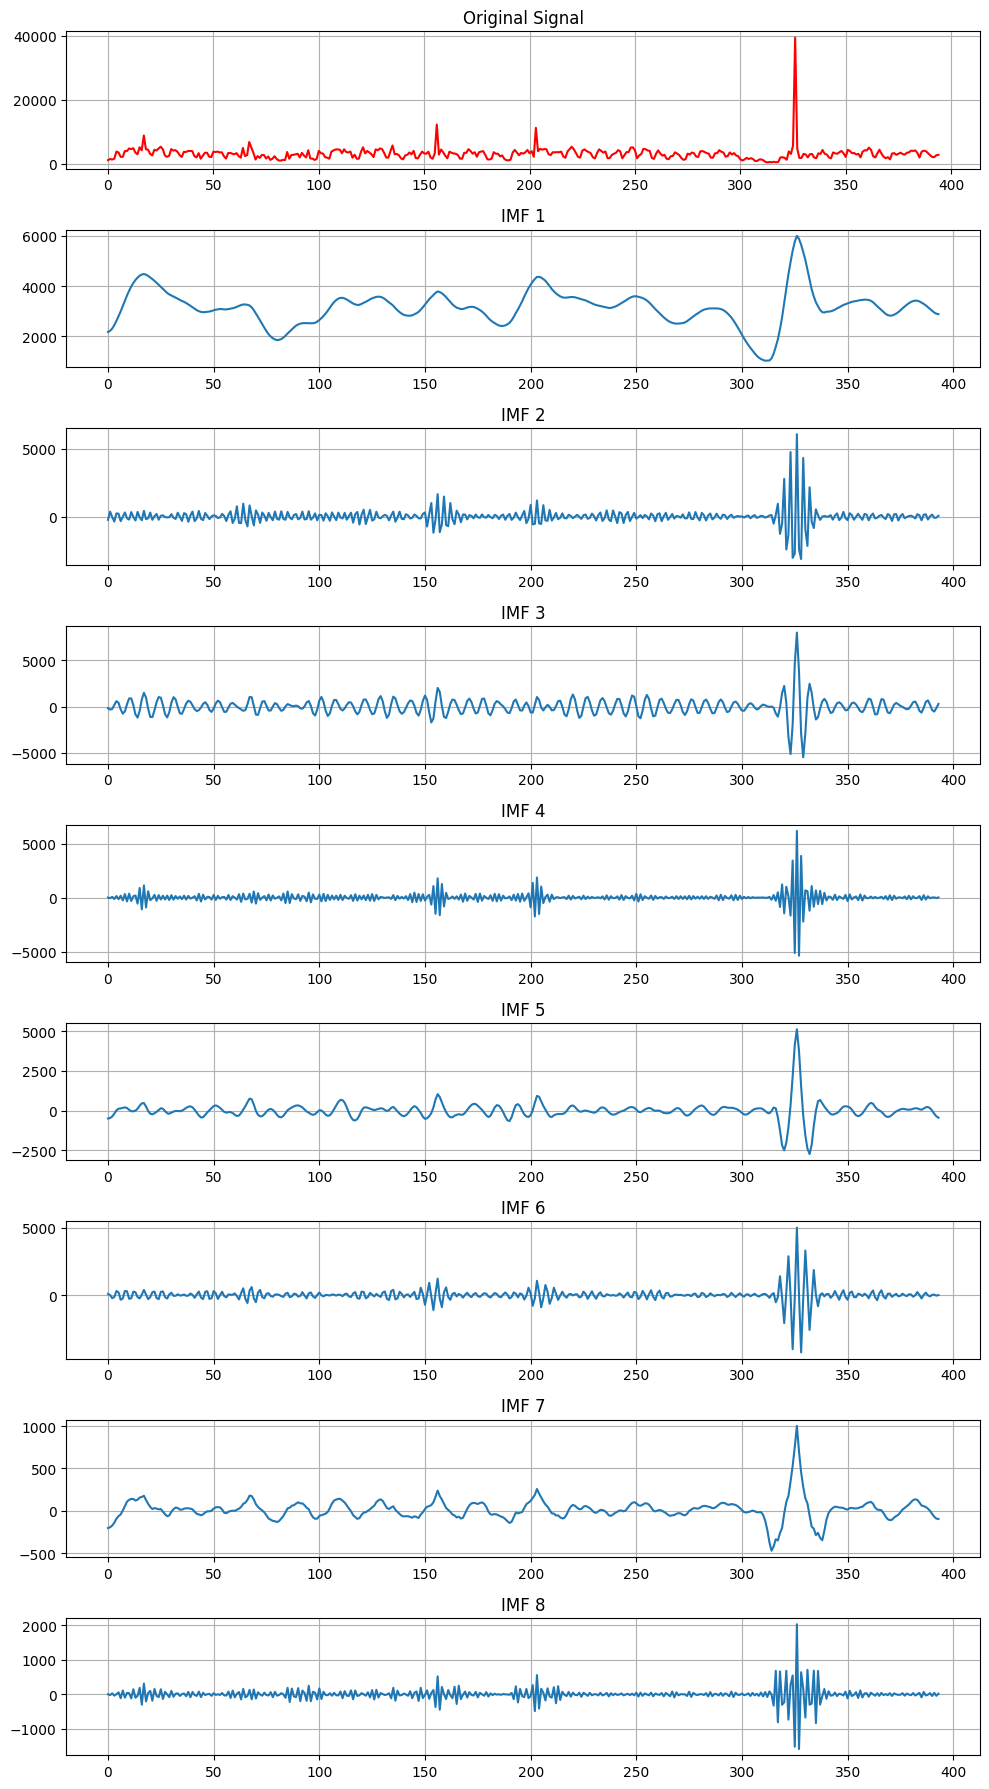

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(u.T)  
plt.show()

lstm.plot_imfs_with_original(data_source, u) 

# VMD 異常資料前處理

IMFs 的數量: 8, 每個 IMF 的長度: 394
將異常部分的值進行平滑處理，imf 1 有 83 個異常點
將異常部分的值進行平滑處理，imf 2 有 31 個異常點
將異常部分的值進行平滑處理，imf 3 有 58 個異常點
將異常部分的值進行平滑處理，imf 4 有 30 個異常點
將異常部分的值進行平滑處理，imf 5 有 31 個異常點
將異常部分的值進行平滑處理，imf 6 有 26 個異常點
將異常部分的值進行平滑處理，imf 7 有 50 個異常點
將異常部分的值進行平滑處理，imf 8 有 38 個異常點
(394,)
(394,)
(394,)
MAE: 339.3786
MAPE: 0.1044


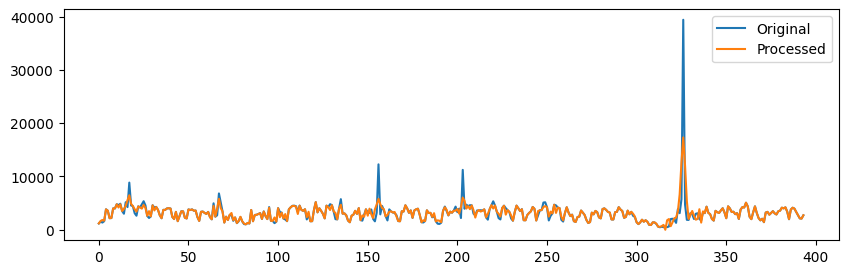

In [7]:
processed_signal = lstm.preprocess_smooth_signal_imfs(u, sigma=sigma, std_threshold=std_num)
original_signal = np.sum(u, axis=0)
# VMD 分解後會少最後一個值，因此要把原始資料的最後一個值去掉
original_data = data_source[:-1].reshape(-1)

print(original_data.shape)
print(processed_signal.shape) 
print(original_signal.shape)

mae = mean_absolute_error(original_data, processed_signal)
mape = mean_absolute_percentage_error(original_signal, processed_signal)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')

plt.figure(figsize=(10, 3))
plt.plot(original_data, label='Original') 
plt.plot(processed_signal, label='Processed')
plt.legend()
plt.show() 

# EEMD 訊號分解

# 訊號分解
EEMD


IMFs shape : (8, 394)
eIMFs shape : (8, 394)
residue shape : (394,)


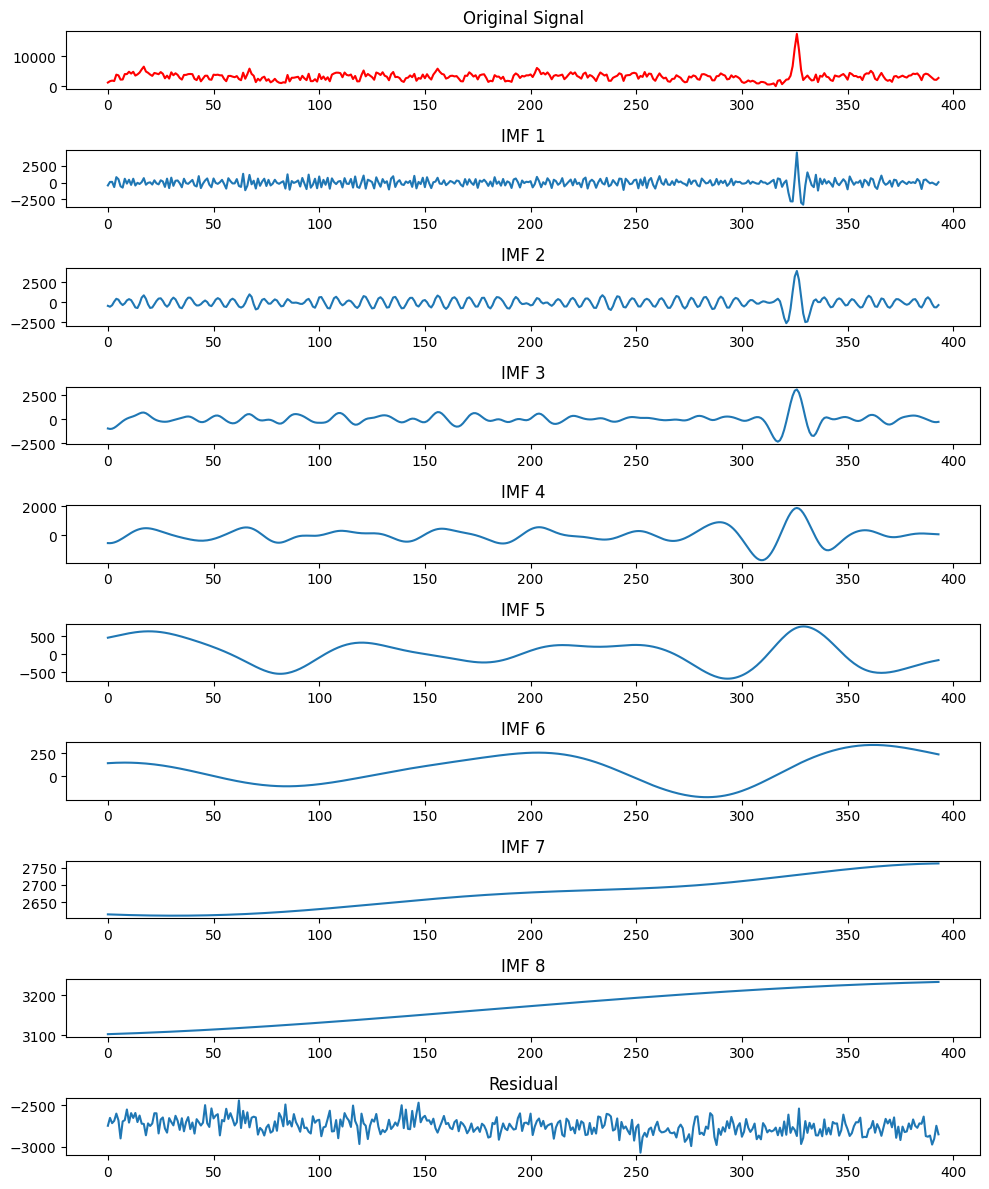

In [8]:
eIMFs, residue, imfs = lstm.decomposition(processed_signal, is_emd = is_emd)

# 刪除訊號分解後的訓練資料

In [9]:
def print_step(index):
    print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
    # 最後一個是殘差
    if index == len(imfs):
        print(f'\x1b[31m殘差\x1b[0m')
    else:
        print(f'\x1b[31m第 {index} 個 IMF\x1b[0m')
        print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
   

for i in range(len(imfs)):
    print_step(i + 1)

    lstm.del_file(x_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(y_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(model_file_name.replace('.keras', f'.{i + 1}.keras'))

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
檔案 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.x_scaler.1.pkl 存在，已刪除
檔案 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.y_scaler.1.pkl 存在，已刪除
檔案 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.model.1.keras 存在，已刪除
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
檔案 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.x_scaler.2.pkl 存在，已刪除
檔案 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.y_scaler.2.pkl 存在，已刪除
檔案 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.model.2.keras 存在，已刪除
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
檔案 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.x_scaler.3

# 最小最大正規化

In [10]:
x_norms = []
y_norms = []
x_scalers = []
y_scalers = []

for i in range(1, len(imfs) + 1):
    print_step(i) 
    x_norm, y_norm, x_scaler, y_scaler = \
        lstm.normalize_by_decomposition(imfs[i - 1]); 

    x_norms.append(x_norm)
    y_norms.append(y_norm)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)
 
    joblib.dump(x_scaler, x_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    joblib.dump(y_scaler, y_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    print('儲存最小最大縮放參數')
  

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 5 個 IMF
---------------------------------

# 切割訓練、驗證和測試資料集

In [11]:
x_trains = []
y_trains = []

x_vals = []
y_vals = []

x_tests = []
y_tests = []

for i in range(len(x_norms)):
    print_step(i + 1)
    
    x_train, y_train, x_val, y_val, x_test, y_test = \
        lstm.train_val_test_split(
            x_norms[i],  
            train_split_rate = train_split_rate,
            val_split_rate = val_split_rate
        )

    x_trains.append(x_train)
    y_trains.append(y_train)

    x_vals.append(x_val)
    y_vals.append(y_val)

    x_tests.append(x_test)
    y_tests.append(y_test)
    

print('\n\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已切割\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_trains len : {len(x_trains)}')
print(f'y_trains len : {len(y_trains)}')
print(f'x_vals len : {len(x_vals)}')
print(f'y_vals len : {len(y_vals)}')
print(f'x_tests len : {len(x_tests)}')
print(f'y_tests len : {len(y_tests)}')


------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 4 個 IMF

# 將資料轉成 LSTM 模型所需資料格式(三維)

In [12]:
x_lstm_trains = []
y_lstm_trains = []

x_lstm_vals = []
y_lstm_vals = []

x_lstm_tests = []
y_lstm_tests = []

for i in range(len(x_trains)):
    print_step(i + 1)
    
    # 訓練集
    x_lstm_train, y_lstm_train, _ = \
        lstm.reshape_data_for_lstm(
            x_trains[i], y_trains[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        ) 
    print('====== Train DataSet ======')
    print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
    print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

    # 驗證集
    x_lstm_val, y_lstm_val, _ = \
        lstm.reshape_data_for_lstm(
            x_vals[i], y_vals[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Val DataSet ======')
    print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
    print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

    # 測試集
    x_lstm_test, y_lstm_test, _ = \
        lstm.reshape_data_for_lstm(
            x_tests[i], y_tests[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Test DataSet ======')
    print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
    print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)
     
    x_lstm_trains.append(x_lstm_train)
    y_lstm_trains.append(y_lstm_train)

    x_lstm_vals.append(x_lstm_val)
    y_lstm_vals.append(y_lstm_val)

    x_lstm_tests.append(x_lstm_test)
    y_lstm_tests.append(y_lstm_test)

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已轉換\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_lstm_trains len : {len(x_lstm_trains)}')
print(f'y_lstm_trains len : {len(y_lstm_trains)}')
print(f'x_lstm_vals len : {len(x_lstm_vals)}')
print(f'y_lstm_vals len : {len(y_lstm_vals)}')
print(f'x_lstm_tests len : {len(x_lstm_tests)}')
print(f'y_lstm_tests len : {len(y_lstm_tests)}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (300, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (300, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗

# 定義 Model

In [13]:
models = []

for i in range(len(x_trains)):
    print_step(i + 1)    
    
    # 定義 Model
    model = lstm.build_model(
        model_type = model_type,
        time_step = past_day,
        n_predictions = future_day
    )
    
    models.append(model)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 定義 Model：2
BiLSTM


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
殘差
# 定義 Model：2
BiLSTM


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [14]:
train_historys = []

for i in range(len(models)):
    print_step(i + 1) 
        
    train_history = lstm.model_fit(
        model = models[i],
        batch_size = batch_size,
        x_train = x_lstm_trains[i],
        y_train = y_lstm_trains[i],
        x_val = x_lstm_vals[i],
        y_val = y_lstm_vals[i],
    ) 
    
    train_historys.append(train_history) 

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
殘差
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [15]:
for i in range(len(models)):
    print_step(i + 1)  
    
    file_name = f'{model_file_name.replace(".keras", f".{i + 1}.keras")}'
    models[i].save(file_name)
    print(f'儲存模型到 {file_name}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.model.1.keras
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.model.2.keras
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.model.3.keras
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.model.4.keras
------------------------------------------------------------------------
第 5 個 IMF
-

# 預測

In [16]:
predict_trains = []
predict_vals = []
predict_tests = []

for i in range(len(models)):
    print_step(i + 1)    
  
    predict_train = lstm.predict(models[i], x_lstm_trains[i])
    print(f'預測 train.shape : {predict_train.shape}')

    predict_val = lstm.predict(models[i], x_lstm_vals[i])
    print(f'預測 val.shape : {predict_val.shape}')

    predict_test = lstm.predict(models[i], x_lstm_tests[i])
    print(f'預測 test.shape : {predict_test.shape}') 
    
    predict_trains.append(predict_train)
    predict_vals.append(predict_val)
    predict_tests.append(predict_test)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [17]:
predict_inverse_trains = []
predict_inverse_vals = []
predict_inverse_tests = []

actual_inverse_trains = []
actual_inverse_vals = []
actual_inverse_tests = []

actual_trains = []
actual_vals = []
actual_tests = []


for i in range(len(models)):
    print_step(i + 1)
    
    # 訓練
    predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_trains[i],
            y_lstm_actual = y_lstm_trains[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_train.shape : {predict_inverse_train.shape}') 
    print(f'actual_inverse_train.shape : {actual_inverse_train.shape}')

    # 驗證
    predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_vals[i],
            y_lstm_actual = y_lstm_vals[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_val.shape : {predict_inverse_val.shape}')
    print(f'actual_inverse_val.shape : {actual_inverse_val.shape}')
    
    # 測試
    predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_tests[i],
            y_lstm_actual = y_lstm_tests[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_test.shape : {predict_inverse_test.shape}')
    print(f'actual_inverse_test.shape : {actual_inverse_test.shape}')

    predict_inverse_trains.append(predict_inverse_train)
    predict_inverse_vals.append(predict_inverse_val)
    predict_inverse_tests.append(predict_inverse_test)

    actual_inverse_trains.append(actual_inverse_train)
    actual_inverse_vals.append(actual_inverse_val)
    actual_inverse_tests.append(actual_inverse_test)

    actual_trains.append(actual_train)
    actual_vals.append(actual_val)
    actual_tests.append(actual_test)
    

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (300, 1)
actual_inverse_train.shape : (300, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (300, 1)
actual_inverse_train.shape : (300, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
-------------------------------------------------------

# 預測資料加總

In [18]:
# 根據原始數據進行切割
x_train_origin, y_train_origin , x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(processed_signal, train_split_rate, val_split_rate)

# 使用原始數據進行 LSTM 模型所需的格式資料轉換
# 主要是為了後面的驗證圖表
y_lstm_origin_train, y_lstm_origin_train, _ = lstm.reshape_data_for_lstm(
    x_train_origin, y_train_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_train = y_lstm_origin_train.reshape(
    y_lstm_origin_train.shape[0], 
    y_lstm_origin_train.shape[1]
)

print(f'x_lstm_origin_train.shape : {y_lstm_origin_train.shape}')
print(f'y_lstm_origin_train.shape : {y_lstm_origin_train.shape}')

x_lstm_origin_test, y_lstm_origin_test, _ = lstm.reshape_data_for_lstm(
    x_test_origin, y_test_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_test = y_lstm_origin_test.reshape(
    y_lstm_origin_test.shape[0], 
    y_lstm_origin_test.shape[1]
)

print(f'x_lstm_origin_test.shape : {x_lstm_origin_test.shape}')
print(f'y_lstm_origin_test.shape : {y_lstm_origin_test.shape}')

x_lstm_origin_val, y_lstm_origin_val, _ = lstm.reshape_data_for_lstm(
    x_val_origin, y_val_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_val = y_lstm_origin_val.reshape(
    y_lstm_origin_val.shape[0], 
    y_lstm_origin_val.shape[1]
)

print(f'x_lstm_origin_val.shape : {x_lstm_origin_val.shape}')
print(f'y_lstm_origin_val.shape : {y_lstm_origin_val.shape}')

# 切割訓練、驗證和測試資料集
x_train.shape: (315,)
y_train.shape: (315,)
x_val.shape: (39,)
y_val.shape: (39,)
x_test.shape: (40,)
y_test.shape: (40,)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_train.shape : (300, 1)
y_lstm_origin_train.shape : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_test.shape : (25, 14)
y_lstm_origin_test.shape : (25, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_val.shape : (24, 14)
y_lstm_origin_val.shape : (24, 1)


In [19]:
predict_inverse_train_sum = np.sum(predict_inverse_trains, axis=0)
actual_inverse_train_sum = np.sum(actual_inverse_trains, axis=0)

predict_inverse_val_sum = np.sum(predict_inverse_vals, axis=0)
actual_inverse_val_sum = np.sum(actual_inverse_vals, axis=0)

predict_inverse_test_sum = np.sum(predict_inverse_tests, axis=0)
actual_inverse_test_sum = np.sum(actual_inverse_tests, axis=0)

print('predict_inverse_train_sum', predict_inverse_train_sum.shape)
print('actual_inverse_train_sum', actual_inverse_train_sum.shape)

print('predict_inverse_val_sum', predict_inverse_val_sum.shape)
print('actual_inverse_val_sum', actual_inverse_val_sum.shape)

print('predict_inverse_test_sum', predict_inverse_test_sum.shape)
print('actual_inverse_test_sum', actual_inverse_test_sum.shape)

predict_inverse_train_sum (300, 1)
actual_inverse_train_sum (300, 1)
predict_inverse_val_sum (24, 1)
actual_inverse_val_sum (24, 1)
predict_inverse_test_sum (25, 1)
actual_inverse_test_sum (25, 1)


# 查看訓練 & 驗證 & 測試集評估數據

In [20]:
for i in range(len(models)):
    print_step(i + 1)
    print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

    print('====== Train Evaluate ======')
    lstm.evaluation(models[i], x_lstm_trains[i], y_lstm_trains[i])
    print('--- 訓練值比較 --- ')
    lstm.score(actual_trains[i], predict_trains[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_trains[i], predict_inverse_trains[i])
    print('')

    print('====== Val Evaluate ======')
    lstm.evaluation(models[i], x_lstm_vals[i], y_lstm_vals[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_vals[i], predict_vals[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_vals[i], predict_inverse_vals[i])
    print('')

    print('====== Test Evaluate ======')
    lstm.evaluation(models[i], x_lstm_tests[i], y_lstm_tests[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_tests[i], predict_tests[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_tests[i], predict_inverse_tests[i])
    print('')
    
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Train Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_train, mape_train = lstm.score(y_lstm_origin_train, predict_inverse_train_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Val Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_val, mape_val = lstm.score(y_lstm_origin_val, predict_inverse_val_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Test Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_test, mape_test = lstm.score(y_lstm_origin_test, predict_inverse_test_sum)
print('')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mean_absolute_percentage_error: 11.3833

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - mean_absolute_percentage_error: 13.2149


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.05259，MAPE:0.12586，MSE:0.00419，RMSE:0.06477，R square:-0.02276
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:406.65375，MAPE:1.64019，MSE:250863.17345，RMSE:500.86243，R square:-0.02276

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mean_absolute_percentage_error: 16.1204

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - mean_absolute_percentage_error: 16.1204


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.07048，MAPE:0.1612，MSE:0.00817，RMSE:0.09041，R square:-0.17179
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:545.0082，MAPE:1.11781，MSE:488835.9504，RMSE:699.16804，R square:-0.17179

====== Test Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mean_absolute_percentage_error: 8.7063

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mean_absolute_percentage_error: 8.7063


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.0359，MAPE:0.08706，MSE:0.00212，RMSE:0.04604，R square:-0.08834
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:277.61481，MAPE:17.59975，MSE:126739.5311，RMSE:356.00496，R square:-0.08834

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8423e-04 - mean_absolute_percentage_error: 4.5238

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0680e-04 - mean_absolute_percentage_error: 5.8921


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.02175，MAPE:0.05745，MSE:0.00076，RMSE:0.02755，R square:0.83882
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:141.93427，MAPE:2.39564，MSE:32317.47252，RMSE:179.77061，R square:0.83882

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0400 - mean_absolute_percentage_error: 151.6519

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0400 - mean_absolute_percentage_error: 151.6519


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.16057，MAPE:1.51652，MSE:0.04005，RMSE:0.20012，R square:-1.56027
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:1047.81154，MAPE:6.85624，MSE:1705323.70464，RMSE:1305.88043，R square:-1.56027

====== Test Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 8.8950

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_absolute_percentage_error: 8.8950


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.03335，MAPE:0.08895，MSE:0.00152，RMSE:0.03896，R square:0.58467
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:217.60908，MAPE:0.92713，MSE:64621.42274，RMSE:254.20744，R square:0.58467

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9345e-05 - mean_absolute_percentage_error: 1.3208

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0466e-05 - mean_absolute_percentage_error: 1.6000


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00695，MAPE:0.01791，MSE:0.00011，RMSE:0.0105，R square:0.96647
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:37.73462，MAPE:0.89063，MSE:3251.26254，RMSE:57.01984，R square:0.96647

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - mean_absolute_percentage_error: 9.7067

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mean_absolute_percentage_error: 9.7067


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02623，MAPE:0.09707，MSE:0.00102，RMSE:0.03197，R square:0.92772
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:142.44907，MAPE:1.45329，MSE:30140.12297，RMSE:173.60911，R square:0.92772

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1695e-05 - mean_absolute_percentage_error: 1.1509

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1695e-05 - mean_absolute_percentage_error: 1.1509


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.005，MAPE:0.01151，MSE:4e-05，RMSE:0.00646，R square:0.9866
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:27.13398，MAPE:0.1965，MSE:1229.68974，RMSE:35.06693，R square:0.9866

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9417e-05 - mean_absolute_percentage_error: 0.8356

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1962e-05 - mean_absolute_percentage_error: 2549.4937


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00474，MAPE:63120772956.18099，MSE:3e-05，RMSE:0.00558，R square:0.99789
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:17.21749，MAPE:0.20475，MSE:411.78897，RMSE:20.29258，R square:0.99789

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2043e-04 - mean_absolute_percentage_error: 5.9592

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2043e-04 - mean_absolute_percentage_error: 5.9592


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.0166，MAPE:0.05959，MSE:0.00042，RMSE:0.0205，R square:0.98677
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:60.30341，MAPE:0.18167，MSE:5551.10183，RMSE:74.50572，R square:0.98677

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0979e-05 - mean_absolute_percentage_error: 0.6509

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0979e-05 - mean_absolute_percentage_error: 0.6509


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00316，MAPE:0.00651，MSE:1e-05，RMSE:0.00331，R square:0.98404
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:11.48592，MAPE:0.47349，MSE:144.96106，RMSE:12.03998，R square:0.98404

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7420e-04 - mean_absolute_percentage_error: 3.5579

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4056e-04 - mean_absolute_percentage_error: 2641.4473


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.0153，MAPE:42956607542.66613，MSE:0.00033，RMSE:0.01815，R square:0.99343
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:22.26318，MAPE:0.40626，MSE:697.04398，RMSE:26.40159，R square:0.99343

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mean_absolute_percentage_error: 7.2615

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mean_absolute_percentage_error: 7.2615


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.05388，MAPE:0.07262，MSE:0.00349，RMSE:0.05906，R square:0.93484
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:78.38489，MAPE:0.6448，MSE:7382.21219，RMSE:85.9198，R square:0.93484

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9514e-04 - mean_absolute_percentage_error: 6.2289

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9514e-04 - mean_absolute_percentage_error: 6.2289


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.01559，MAPE:0.06229，MSE:0.0003，RMSE:0.01718，R square:0.94927
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:22.6769，MAPE:0.0845，MSE:624.64367，RMSE:24.99287，R square:0.94927

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1994e-06 - mean_absolute_percentage_error: 0.2885

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1612e-06 - mean_absolute_percentage_error: 1121.7340


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00263，MAPE:18217071629.75561，MSE:1e-05，RMSE:0.00334，R square:0.99982
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:1.4717，MAPE:0.05565，MSE:3.50494，RMSE:1.87215，R square:0.99982

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1009e-05 - mean_absolute_percentage_error: 0.5334

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1009e-05 - mean_absolute_percentage_error: 0.5334


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00447，MAPE:0.00533，MSE:2e-05，RMSE:0.00458，R square:0.99706
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:2.50417，MAPE:0.01028，MSE:6.58729，RMSE:2.56657，R square:0.99706

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9016e-05 - mean_absolute_percentage_error: 0.9161

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.9016e-05 - mean_absolute_percentage_error: 0.9161


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00813，MAPE:0.00916，MSE:8e-05，RMSE:0.00889，R square:0.97055
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:4.55155，MAPE:0.01661，MSE:24.77503，RMSE:4.97745，R square:0.97055

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7854e-07 - mean_absolute_percentage_error: 17978.0293

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5471e-06 - mean_absolute_percentage_error: 4972.6157 


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.0014，MAPE:8331845086.547，MSE:0.0，RMSE:0.00173，R square:0.99994
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.21407，MAPE:8e-05，MSE:0.06982，RMSE:0.26423，R square:0.99994

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3620e-05 - mean_absolute_percentage_error: 0.5647

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3620e-05 - mean_absolute_percentage_error: 0.5647


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00482，MAPE:0.00565，MSE:2e-05，RMSE:0.00486，R square:0.97543
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.73807，MAPE:0.00027，MSE:0.55321，RMSE:0.74378，R square:0.97544

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.1556e-05 - mean_absolute_percentage_error: 0.9136

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1556e-05 - mean_absolute_percentage_error: 0.9136


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.009，MAPE:0.00914，MSE:8e-05，RMSE:0.00903，R square:0.51237
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:1.37678，MAPE:0.0005，MSE:1.91038，RMSE:1.38216，R square:0.51235

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.1764e-07 - mean_absolute_percentage_error: 2.0216

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4206e-06 - mean_absolute_percentage_error: 0.9851


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00102，MAPE:0.00557，MSE:0.0，RMSE:0.00117，R square:0.99998
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.13383，MAPE:4e-05，MSE:0.02351，RMSE:0.15334，R square:0.99998

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8420e-06 - mean_absolute_percentage_error: 0.2380

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8420e-06 - mean_absolute_percentage_error: 0.2380


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.0022，MAPE:0.00238，MSE:0.0，RMSE:0.0022，R square:0.9718
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.28922，MAPE:9e-05，MSE:0.08365，RMSE:0.28923，R square:0.9718

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7186e-06 - mean_absolute_percentage_error: 0.1278

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7186e-06 - mean_absolute_percentage_error: 0.1278


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00126，MAPE:0.00128，MSE:0.0，RMSE:0.00131，R square:0.97747
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.16528，MAPE:5e-05，MSE:0.02969，RMSE:0.17231，R square:0.97748

------------------------------------------------------------------------
殘差
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179 - mean_absolute_percentage_error: 20.6399

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - mean_absolute_percentage_error: 649246.1250


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.11609，MAPE:7633051669845.6，MSE:0.02168，RMSE:0.14725，R square:0.0561
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:72.72335，MAPE:0.02643，MSE:8509.65799，RMSE:92.24781，R square:0.0561

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - mean_absolute_percentage_error: 27.1151

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - mean_absolute_percentage_error: 27.1151


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.10937，MAPE:0.27115，MSE:0.01606，RMSE:0.12671，R square:-0.18734
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:68.51252，MAPE:0.02452，MSE:6300.84307，RMSE:79.37785，R square:-0.18734

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0264 - mean_absolute_percentage_error: 41.0151

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0264 - mean_absolute_percentage_error: 41.0151


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.12693，MAPE:0.41015，MSE:0.02642，RMSE:0.16255，R square:-0.32899
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:79.51863，MAPE:0.02808，MSE:10369.08062，RMSE:101.82868，R square:-0.32899

------------------------------------------------------------------------
合併後 Train Evaluate
------------------------------------------------------------------------
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:438.29458，MAPE:0.16486，MSE:304583.31156，RMSE:551.89067，R square:0.73559

------------------------------------------------------------------------
合併後 Val Evaluate
------------------------------------------------------------------------
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:1176.25166，MAPE:0.46677，MSE:2179055.48358，RMSE:1476.16242，R square:-2.21811

------------------------------------------------------------------------
合併後 Test Evaluate
---------------------------------------------------------------

# 顯示原始數據圖表

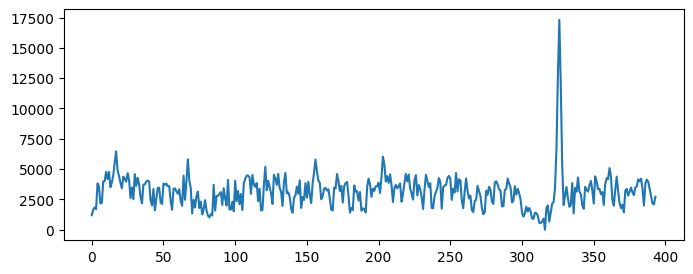

In [21]:
plt.figure(figsize=(8, 3))
plt.plot(processed_signal)
plt.show()

## 訓練集

原始資料 (315,)
[569.13284768 544.731293   674.86182177]
原始資料2 (300, 1)
[[569.13284768]
 [544.731293  ]
 [674.86182177]]
還原原始資料 (300, 1)
[[-2798.11172193]
 [-2816.01631241]]


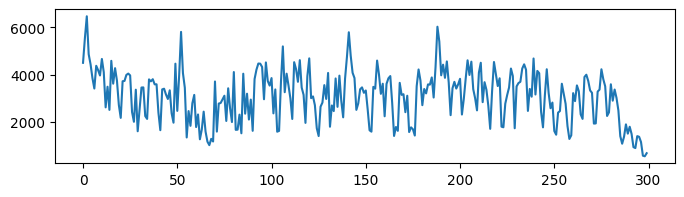

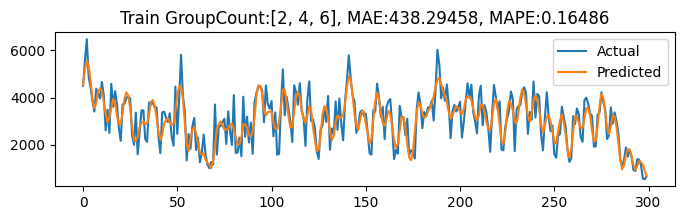

In [22]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('原始資料2', y_lstm_origin_train.shape)
print(y_lstm_origin_train[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_train,
    predict = predict_inverse_train_sum,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39,)
[4400.57535644 3991.96458219 3341.80981582]
原始資料2 (24, 1)
[[4400.57535644]
 [3991.96458219]
 [3341.80981582]]
還原原始資料 (24, 1)
[[-2836.87661128]
 [-2753.02017844]]


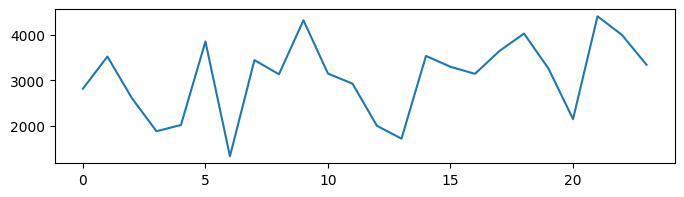

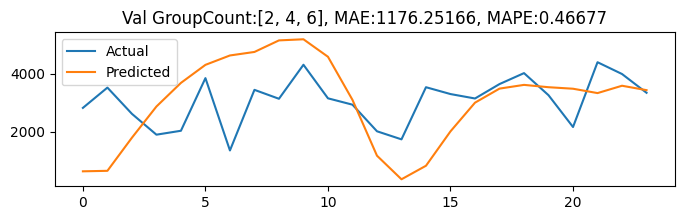

In [23]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('原始資料2', y_lstm_origin_val.shape)
print(y_lstm_origin_val[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_val,
    predict = predict_inverse_val_sum,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40,)
[2145.77736    2092.40426935 2719.53163078]
原始資料2 (25, 1)
[[2145.77736   ]
 [2092.40426935]
 [2719.53163078]]
還原原始資料 (25, 1)
[[-2747.66960064]
 [-2850.26289756]]
Test GroupCount:[2, 4, 6], BatchSize:14, MAE:398.12899, MAPE:0.15124


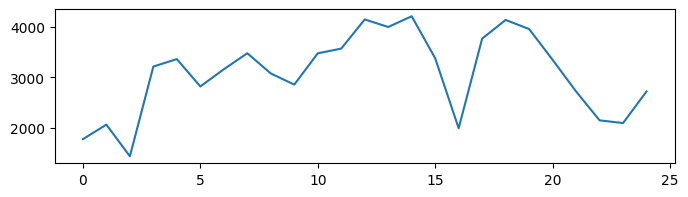

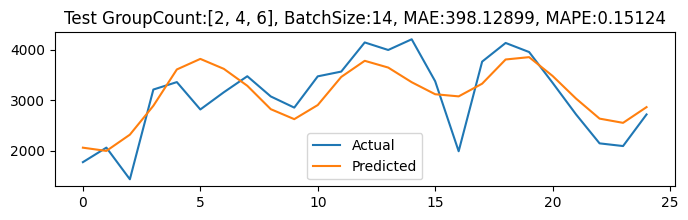

In [24]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('原始資料2', y_lstm_origin_test.shape)
print(y_lstm_origin_test[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:]) 

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'
print(title)

lstm.show_predict_chart(
    actual = y_lstm_origin_test,
    predict = predict_inverse_test_sum,
    title = title
)

# 儲存結果

In [25]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    imfs = len(imfs)
)

{'type': 'VMD_DecompEEMD', 'labels': ['GroupCount'], 'model_type': 2, 'predicteds': [2, 4, 6], 'batch_size': 14, 'train_mae': 438.29458, 'train_mape': 0.16486, 'test_mae': 398.12899, 'test_mape': 0.15124, 'kfold': None, 'imfs': 9}
儲存評估結果到 VMD_DecompEEMD/_Model/GroupCount_mt2_data246_batch14.result.json
